In [75]:
from datasets import load_dataset, Dataset
from IPython.display import display
from PIL import Image
import numpy as np
import pandas as pd
import pycountry
from pprint import pprint
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from matplotlib.lines import Line2D
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Model imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Pytorch imports
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
dl_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(f"I will use deep learning models using {dl_device}!")

I will use deep learning models using cuda!


In [4]:
# Load the vgg16 model which will be used to extract image embeddings
vgg_16_model = models.vgg16(pretrained=True).to(dl_device)
vgg_16_model.eval()

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Copy the model without the final classifier layer
vgg_embedding_model = torch.nn.Sequential(*list(vgg_16_model.children())[:-1]).to(dl_device)

In [6]:
def alpha2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

# Loading Data and exploring it

#### We will apply to only 5 countries in the reserach for easier analysis, faster training times and specified answers
Israel, USA, Japan, Nigeria, Denmark 


In [6]:
# Exploration and pre-processing functions and parameters

# Select only Israel, USA, Japan, Nigeria and Denmark as countries from the dataset
SELECTED_COUNTRIES = ('IL','US','JP','NG','DE')

def keep_samples_by_label(sample):
    return sample["label"] in SELECTED_COUNTRIES


def build_array_df_from_dataset(dataset, to_grey_scale: bool = False) -> pd.DataFrame:
    def process_sample(sample):
        return {
            "image_array": np.array(sample["image"].resize((128, 128)) if not to_grey_scale else sample["image"].convert("L").resize((128,128))),
            "label": sample["label"]
        }    

    processed_filtered_ds = dataset.map(process_sample)
    df = pd.DataFrame({
    "image_array": processed_filtered_ds["image_array"],
    "label": processed_filtered_ds["label"]
    })

    return df

def flatten_image_dataframe(df, image_col='image_array', label_col='label'):
    """
    Converts a DataFrame with grayscale or RGB images into a flat format:
    - Each pixel/channel becomes a column (unnamed numeric index).
    - The label is added as the final column.

    Parameters:
        df (pd.DataFrame): DataFrame with image vectors and labels.
        image_col (str): Column name containing image data.
        label_col (str): Column name containing labels.

    Returns:
        pd.DataFrame: Flattened DataFrame with pixel values and label.
    """
    def flatten_image(img):
        arr = np.array(img)
        if arr.ndim == 2:
            return arr.flatten()
        elif arr.ndim == 3:
            return arr.transpose(2, 0, 1).flatten()
        else:
            raise ValueError(f"Unsupported image shape: {arr.shape}")

    # Flatten images
    flat_pixels = df[image_col].apply(flatten_image).to_list()
    pixel_df = pd.DataFrame(flat_pixels)

    # Append label as last column
    pixel_df[label_col] = df[label_col].values

    return pixel_df

In [7]:
# Load the datasets
# Those datasets are related to the images only. Will be used for training DL and MLP models.
dataset = load_dataset("nateraw/country211")
dataset_train, dataset_validation, dataset_test = dataset["train"], dataset["validation"], dataset["test"]
datasets = (dataset_train, dataset_validation, dataset_test)

In [8]:
# This is a callable that saves the mapping of labels to their string representation
label2country = dataset_train.features["label"].int2str

# This is the inverse of the above
country2label = dataset_train.features["label"].str2int

def count_labels(label_column: np.ndarray) -> dict:
    labels_as_strings = list(label2country(label_column))

    counts = Counter(labels_as_strings)
    return dict(counts)

In [9]:
# This line of code filters the given datasets to ones that only contain countries from the SELECTED_COUNTRIES list.
datasets_filtered = tuple(dataset.filter(lambda sample: label2country(sample["label"]) in SELECTED_COUNTRIES) for dataset in datasets)

In [10]:
# Those datasets should be used when working with the deep learning models (VGG, ResNet).
dataset_train_filtered, dataset_validation_filtered, dataset_test_filtered = datasets_filtered

In [11]:
print("Dataset Shapes Before   ->  After")
print(f"Train:       {dataset_train.shape} -> {dataset_train_filtered.shape}")
print(f"Validation:  {dataset_validation.shape} -> {dataset_validation_filtered.shape}")
print(f"Test:        {dataset_test.shape} -> {dataset_test_filtered.shape}")

Dataset Shapes Before   ->  After
Train:       (31650, 2) -> (750, 2)
Validation:  (10550, 2) -> (250, 2)
Test:        (21100, 2) -> (500, 2)


### With the new datasets of filtered countries, we can begin working on the questions

However, in order to work with traditional ML, which in our case will be SVM, AdaBoost and Random Forest, we need an array of features. For that the data will be transformed to arrays, and in the case of colored images, 3d arrays. 

3D arrays while representative, pose an issue with training for traditional ML. It is usually recommended to use 1d arrays that represent features. In the case of images, each pixel can be seen as a feature but it has the trade-off of losing relational information of neighboring pixels. Therefore, flattering will be required, but at a cost of model accuracy which we will later see.

In the following section, we will create 2 types of dataframes: One of RGB images as array, and one as greyscale images as array. Those will also be flattened in order to support training them with ML tasks and with exploring by PCA 

In [12]:
# Build the relevant dataframes for future data exploration and analysis 

print("Building RGB dataframes")
data_frames_rgb = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=False) for filtered_ds in datasets_filtered)

print("Flattening RGB dataframes")
data_frames_rgb_flattened = tuple(flatten_image_dataframe(filtered_ds_rgb) for filtered_ds_rgb in data_frames_rgb)

print("Building greyscale dataframes")
data_frames_grey = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=True) for filtered_ds in datasets_filtered)

print("Flattening greyscale dataframes")
data_frames_grey_flattened = tuple(flatten_image_dataframe(filtered_ds_grey) for filtered_ds_grey in data_frames_grey)

# NOTE: The new dataframes are also filtered and following data-frames should be assumed as filtered except the very first datasets imported.

Building RGB dataframes
Flattening RGB dataframes
Building greyscale dataframes
Flattening greyscale dataframes


In [13]:
df_train_rgb, df_validation_rgb, df_test_rgb = data_frames_rgb
df_train_rgb_flattened, df_validation_rgb_flattened, df_test_rgb_flattened = data_frames_rgb_flattened

df_train_grey, df_validation_grey, df_test_grey = data_frames_grey
df_train_grey_flattened, df_validation_grey_flattened, df_test_grey_flattened = data_frames_grey_flattened

In [14]:
# Several assertions to check order of labels stays the same

assert df_train_rgb['label'].equals(df_train_rgb_flattened['label'])
assert df_validation_rgb['label'].equals(df_validation_rgb_flattened['label'])
assert df_test_rgb['label'].equals(df_test_rgb_flattened['label'])

assert df_train_grey['label'].equals(df_train_grey_flattened['label'])
assert df_validation_grey['label'].equals(df_validation_grey_flattened['label'])
assert df_test_grey['label'].equals(df_test_grey_flattened['label'])

In [15]:
# Checking data instability

print(f"Images train data label counts:      {count_labels(dataset_train_filtered["label"])}")
print(f"Images validation data label counts: {count_labels(dataset_validation_filtered["label"])}")
print(f"Images test data label counts:       {count_labels(dataset_test_filtered["label"])}")

print()

print(f"DF-RGB train data label counts:      {count_labels(df_train_rgb["label"])}")
print(f"DF-RGB validation data label counts: {count_labels(df_validation_rgb["label"])}")
print(f"DF-RGB test data label counts:       {count_labels(df_test_rgb["label"])}")

print()

print(f"DF-grey train data label counts:      {count_labels(df_train_grey["label"])}")
print(f"DF-grey validation data label counts: {count_labels(df_validation_grey["label"])}")
print(f"DF-grey test data label counts:       {count_labels(df_test_grey["label"])}")


Images train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
Images validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
Images test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-RGB train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-RGB validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-RGB test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-grey train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-grey validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-grey test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}


## Q1

This leads to exploring one of the questions: Can we present if the countries are similar and which are different based on the features alone? In order to visualize it we need to use PCA, which is a dimentionality reduction technique that preserves the variance with a fixed number of dimentions. We can reduce to 3 or 2 dimentions but retain the information.

In addition, we will also present calculations that determine which countries are most similar, and which are most different. This and PCA will be applied with both the feature vectors but also with image embedding we will introduce later.

In [16]:
def plot_pca_subplot(X_pca, labels, n_components=2, title="PCA Projection", ax=None, cmap='Set3'):
    unique_labels, labels_numeric = np.unique(labels, return_inverse=True)

    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1, projection='3d' if n_components == 3 else None)

    if n_components == 2:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, cmap=cmap, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    else:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_numeric, cmap=cmap, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

    ax.set_title(title)

    # Build legend info — but only return it (do not add to ax here)
    handles, _ = scatter.legend_elements()
    return handles, unique_labels

def plot_subplots_pca(data_frames, save_plot = True, sup_title = "PCA Visualization", file_name = "PCA_Subplots"):
    # Setup figure
    n_datasets = len(data_frames)
    fig, axes = plt.subplots(2, n_datasets, figsize=(5 * n_datasets, 10), subplot_kw={'projection': None})
    fig.suptitle(sup_title, fontsize=18, y=0.98)
    
    # Convert to 2D array even if n_datasets == 1
    if n_datasets == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    
    # Track handles/labels for universal legend
    shared_handles, shared_labels = None, None
    
    for i, (X2d, X3d, y, title) in enumerate(data_frames):
        # Top row: 2D
        ax2d = axes[0, i]
        handles, labels = plot_pca_subplot(X2d, y, ax=ax2d, n_components=2, title=f"{title}")
        if shared_handles is None:
            shared_handles, shared_labels = handles, labels
    
        # Bottom row: 3D
        ax3d = fig.add_subplot(2, n_datasets, n_datasets + i + 1, projection='3d')  # manually insert into fig
        plot_pca_subplot(X3d, y, ax=ax3d, n_components=3, title=f"{title}")
    
    # Shared legend
    fig.legend(shared_handles, shared_labels, title="Labels", loc='lower center',
               bbox_to_anchor=(0.5, 0.01), ncol=len(shared_labels))
    
    # Layout adjustments
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    if save_plot:
        fig.savefig(f"{file_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
# Start with obtaining X and y matrices from each dataframe for PCA analysis and model training.
# All of those are PCA and model ready matrices. Use those!

X_y_matrices_rgb = tuple((flattened_df.iloc[:, :-1].to_numpy(), flattened_df.iloc[:, -1].to_numpy()) for flattened_df in data_frames_rgb_flattened)
X_y_matrices_grey = tuple((flattened_df.iloc[:, :-1].to_numpy(), flattened_df.iloc[:, -1].to_numpy()) for flattened_df in data_frames_grey_flattened)

X_train_rgb, y_train_rgb = X_y_matrices_rgb[0]
X_validation_rgb, y_validation_rgb = X_y_matrices_rgb[1]
X_test_rgb, y_test_rgb = X_y_matrices_rgb[2]

X_train_grey, y_train_grey = X_y_matrices_grey[0]
X_validation_grey, y_validation_grey = X_y_matrices_grey[1]
X_test_grey, y_test_grey = X_y_matrices_grey[2]

In [18]:
print(f"RGB flattened data shape:  {X_train_rgb.shape}")
print(f"grey flattened data shape: {X_train_grey.shape}")

RGB flattened data shape:  (750, 49152)
grey flattened data shape: (750, 16384)


In [19]:
splits = ("train", "val", "test")
scaler = StandardScaler()
pca_2d, pca_3d = PCA(n_components=2), PCA(n_components=3)

pca_datasets = []

for split, (X_rgb, y_rgb) in zip(splits, X_y_matrices_rgb):
    print(f"Processing PCA for rgb-{split}")
    if split == "train":
        X_rgb_scaled = scaler.fit_transform(X_rgb)
        X_rgb_scaled_pca2 = pca_2d.fit_transform(X_rgb_scaled)
        X_rgb_scaled_pca3 = pca_3d.fit_transform(X_rgb_scaled)
    else:
        X_rgb_scaled = scaler.transform(X_rgb)
        X_rgb_scaled_pca2 = pca_2d.transform(X_rgb_scaled)
        X_rgb_scaled_pca3 = pca_3d.transform(X_rgb_scaled)

    labels_rgb = label2country(y_rgb)

    pca_datasets.append((X_rgb_scaled_pca2, X_rgb_scaled_pca3, labels_rgb, f"RGB {split}"))

for split, (X_grey, y_grey) in zip(splits, X_y_matrices_grey):
    print(f"Processing PCA for grey-{split}")
    if split == "train":
        X_grey_scaled = scaler.fit_transform(X_grey)
        X_grey_scaled_pca2 = pca_2d.fit_transform(X_grey_scaled)
        X_grey_scaled_pca3 = pca_3d.fit_transform(X_grey_scaled)
    else:
        X_grey_scaled = scaler.transform(X_grey)
        X_grey_scaled_pca2 = pca_2d.transform(X_grey_scaled)
        X_grey_scaled_pca3 = pca_3d.transform(X_grey_scaled)

    labels_grey = label2country(y_grey)

    pca_datasets.append((X_grey_scaled_pca2, X_grey_scaled_pca3, labels_grey, f"grey {split}"))
            
        
    

Processing PCA for rgb-train
Processing PCA for rgb-val
Processing PCA for rgb-test
Processing PCA for grey-train
Processing PCA for grey-val
Processing PCA for grey-test


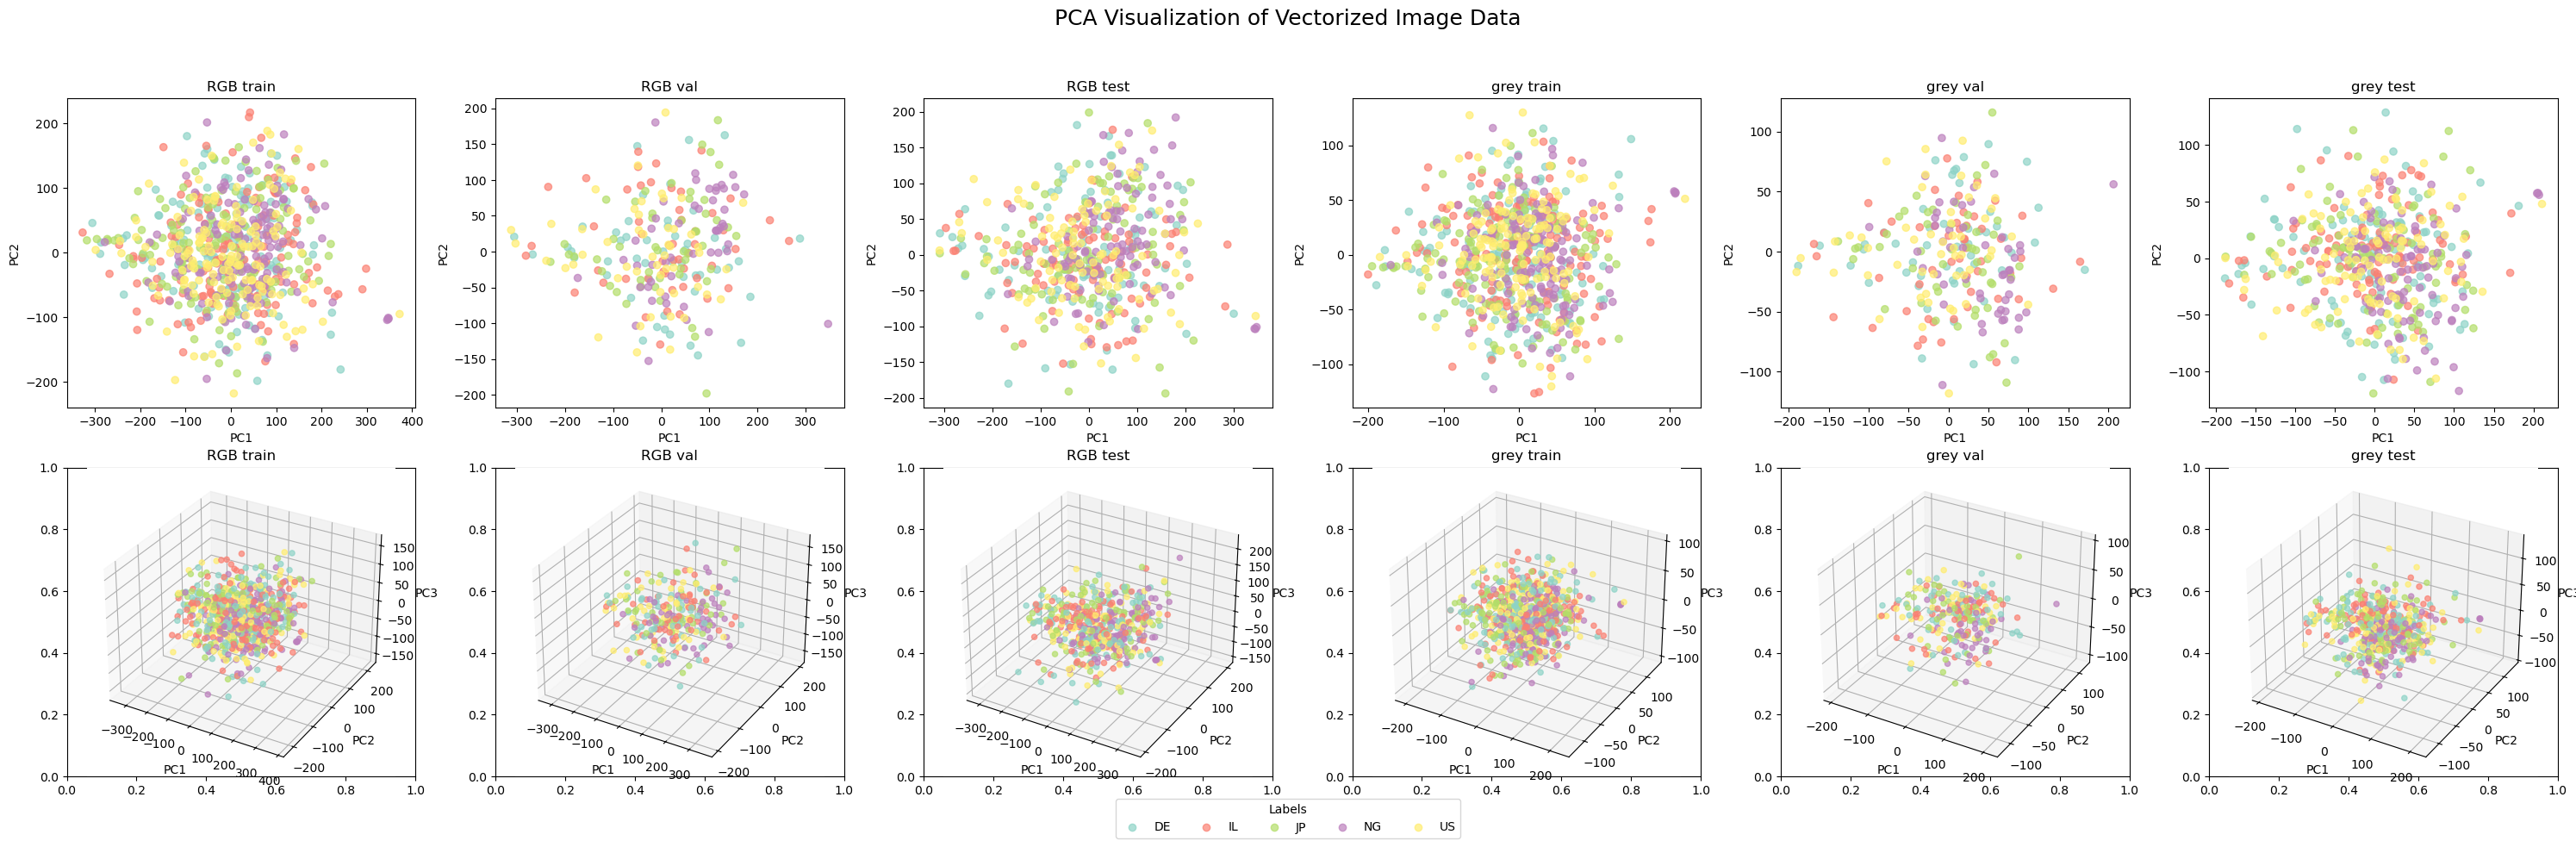

In [20]:
plot_subplots_pca(pca_datasets, sup_title="PCA Visualization of Vectorized Image Data", file_name = "PCA_Vectorized_Data")

As we can observe, the data points just go all around without clear grouping, which is to be expected when we only consider pixels as features. For the next experiment, we will produce image embeddings with VGG-16 pre-trained model across the datasets and see if this can improve PCA projections. 

The first steps will be creating new dataframes such that each picture is represented with the appropriate embedding for later PCA processing

In [21]:
# Image transformation pipeline for the images
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [22]:
# Define wrapper for country211 datasets
class HuggingfaceCountryDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

In [23]:
# Those loaders can be used for future DL models used with Pytorch :)
filtered_ds_loaders = []

for dataset_filtered in datasets_filtered:
    torch_dataset = HuggingfaceCountryDataset(dataset_filtered, transform=img_transform)
    torch_loader = DataLoader(torch_dataset, batch_size=32, shuffle=False)
    filtered_ds_loaders.append(torch_loader)

In [25]:
# Those data-frames can be used for future DL models used with Pytorch :)

vgg_data_frames = []
splits = ("train", "val", "test")

with torch.no_grad():
    for split, torch_loader in zip(splits, filtered_ds_loaders):
        embeddings = []
        embeddings_labels = []
        
        for imgs, lbls in tqdm(torch_loader, desc = f"Embedding {split} data and saving to separate dataframe"):
            imgs = imgs.to(dl_device)
            feats = vgg_embedding_model(imgs)           # (B, 512, 7, 7)
            vecs = feats.view(feats.size(0), -1)     # (B, 25088)
            embeddings.append(vecs.cpu().numpy())
            embeddings_labels.extend(lbls.cpu().numpy().tolist())

        embeddings = np.vstack(embeddings)
        df_vgg_embeddings = pd.DataFrame(embeddings)
        df_vgg_embeddings['label'] = embeddings_labels
        vgg_data_frames.append(df_vgg_embeddings)

Embedding train data and saving to separate dataframe: 100%|██████████████████████████████████| 24/24 [00:08<00:00,  2.73it/s]
Embedding val data and saving to separate dataframe: 100%|██████████████████████████████████████| 8/8 [00:03<00:00,  2.65it/s]
Embedding test data and saving to separate dataframe: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.71it/s]


In [26]:
X_y_matrices_vgg = tuple((vgg_df.iloc[:, :-1].to_numpy(), vgg_df.iloc[:, -1].to_numpy()) for vgg_df in vgg_data_frames)

X_train_vgg, y_train_vgg = X_y_matrices_vgg[0]
X_validation_vgg, y_validation_vgg = X_y_matrices_vgg[1]
X_test_vgg, y_test_vgg = X_y_matrices_vgg[2]

In [27]:
vgg_scaler = StandardScaler()
pca_2d, pca_3d = PCA(n_components=2), PCA(n_components=3)
splits = ("train", "val", "test")


vgg_pca_datasets = []

for split, (X_vgg, y_vgg) in zip(splits, X_y_matrices_vgg):
    print(f"Processing PCA for vgg-{split}")
    if split == "train":
        X_vgg_scaled = vgg_scaler.fit_transform(X_vgg)
        X_vgg_scaled_pca2 = pca_2d.fit_transform(X_vgg_scaled)
        X_vgg_scaled_pca3 = pca_3d.fit_transform(X_vgg_scaled)
    else:
        X_vgg_scaled = vgg_scaler.transform(X_vgg)
        X_vgg_scaled_pca2 = pca_2d.transform(X_vgg_scaled)
        X_vgg_scaled_pca3 = pca_3d.transform(X_vgg_scaled)

    labels_vgg = label2country(y_vgg)

    vgg_pca_datasets.append((X_vgg_scaled_pca2, X_vgg_scaled_pca3, labels_vgg, f"vgg {split}"))

Processing PCA for vgg-train
Processing PCA for vgg-val
Processing PCA for vgg-test


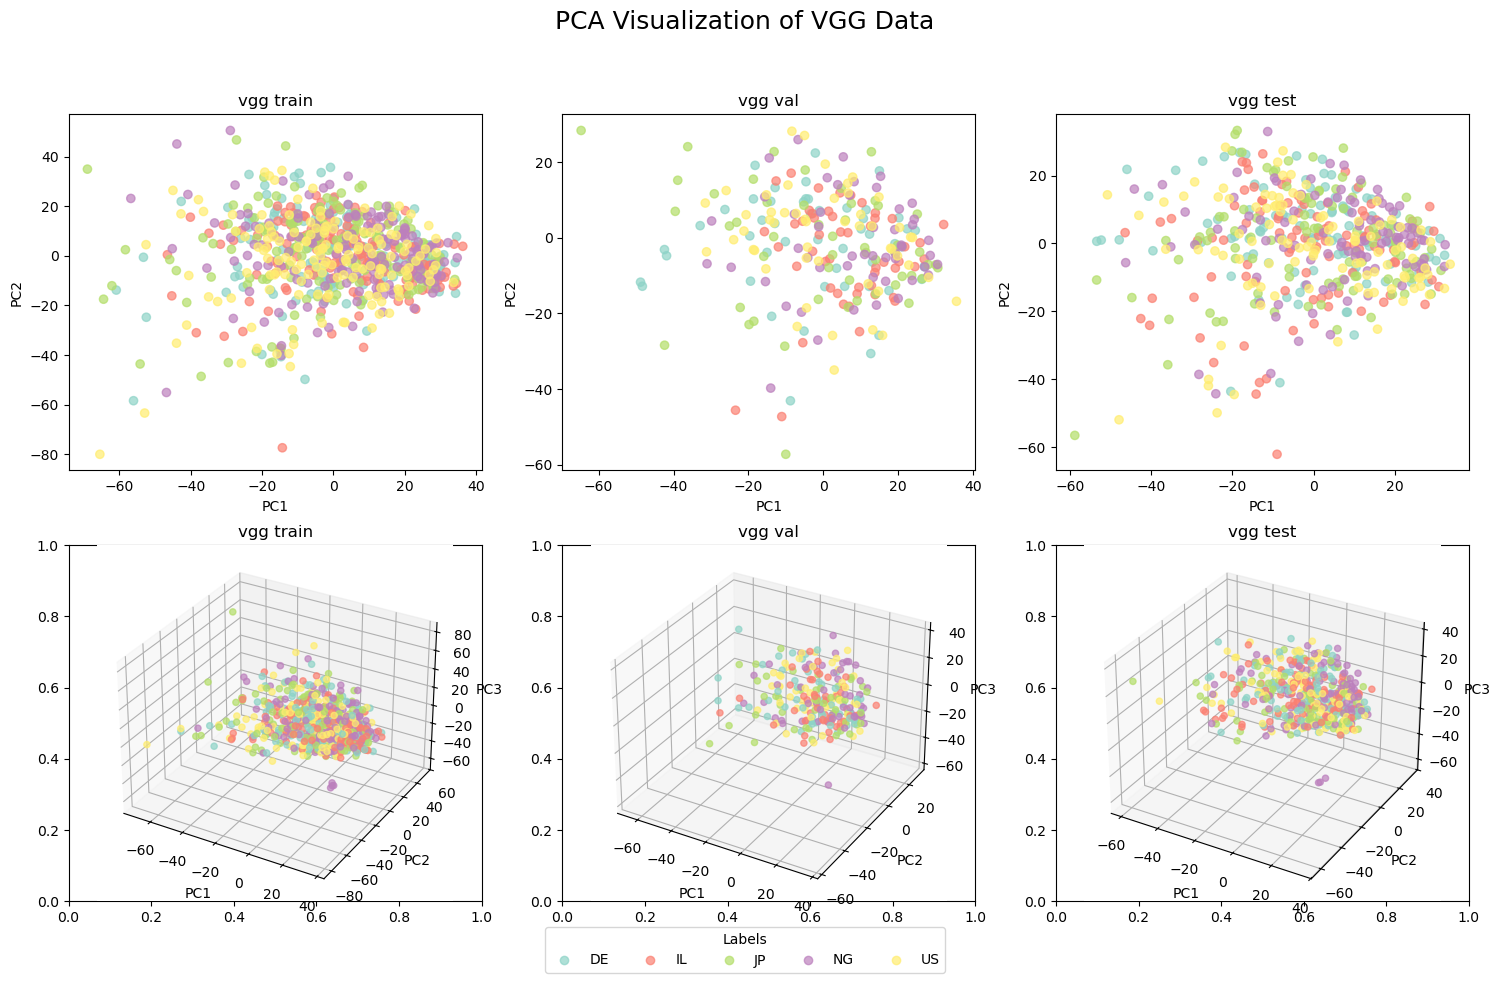

In [28]:
plot_subplots_pca(vgg_pca_datasets, sup_title="PCA Visualization of VGG Data", file_name="PCA_VGG_Data")

We notice a change in PCA results when using image embeddings, but it is still chaotic and clustering is not as trivial.

Now we will calculate simiality and difference across the different kinds of datasets using cosine similarity.

In [109]:
def plot_similarity_matrix(sim_matrix, labels, title="Cosine Similarity", max_labels=30):
    # Limit to top-N labels for clarity
    sim_matrix = sim_matrix[:max_labels, :max_labels]
    labels = labels[:max_labels]

    fig, ax = plt.subplots(figsize=(11, 8))
    cax = ax.imshow(sim_matrix, cmap='viridis')

    # Color bar
    fig.colorbar(cax)

    # Axis ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)

    # Title
    ax.set_title(title, fontsize=16)

    # Annotate each cell with similarity value
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                continue
            value = sim_matrix[i, j]
            ax.text(j, i, f"{value:.4f}", ha='center', va='center',
                    color='white', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [45]:
def plot_similarity_on_ax(sim_matrix, labels, ax, title="", max_labels=30):
    sim_matrix = sim_matrix[:max_labels, :max_labels]
    labels = labels[:max_labels]

    cax = ax.imshow(sim_matrix, cmap='viridis')

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=7)
    ax.set_yticklabels(labels, fontsize=7)

    ax.set_title(title, fontsize=10)

    # Optional: annotate values
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                continue
            ax.text(j, i, f"{sim_matrix[i, j]:.4f}", ha='center', va='center', color='white', fontsize=11)

    return cax


def plot_3x3_similarity_superplot(sim_matrices_rgb, sim_matrices_grey, sim_matrices_vgg, max_labels=30, save_fig=True):
    row_titles = ["RGB", "Greyscale", "VGG"]
    col_titles = ["Train", "Validation", "Test"]

    all_data = [sim_matrices_rgb, sim_matrices_grey, sim_matrices_vgg]

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    for row in range(3):  # input types
        for col in range(3):  # splits
            sim_matrix, country_names = all_data[row][col]
            ax = axes[row, col]
            title = f"{row_titles[row]} - {col_titles[col]}"
            cax = plot_similarity_on_ax(sim_matrix, country_names, ax, title=title, max_labels=max_labels)
            fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle("Cosine Similarity plot of vectorized RGB, Grey and VGG embeddings across splits.")
    plt.tight_layout()
    if save_fig:
        fig.savefig(f"Cosine_similarity_rgb_grey_vgg.png", dpi=300, bbox_inches='tight')
    
    plt.show()

In [29]:
rgb_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in data_frames_rgb_flattened
))

grey_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in data_frames_grey_flattened
))

vgg_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in vgg_data_frames
))

In [32]:
sim_matrices_rgb, sim_matrices_grey, sim_matrices_vgg = [], [], []

for data_frame in rgb_data_frames_for_cosine:
    data_frame["label"] = data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_rgb.append((similarity_matrix, country_names))

for data_frame in grey_data_frames_for_cosine:
    data_frame["label"] = data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_grey.append((similarity_matrix, country_names))

for data_frame in vgg_data_frames_for_cosine:
    data_frame["label"] = data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_vgg.append((similarity_matrix, country_names))
    

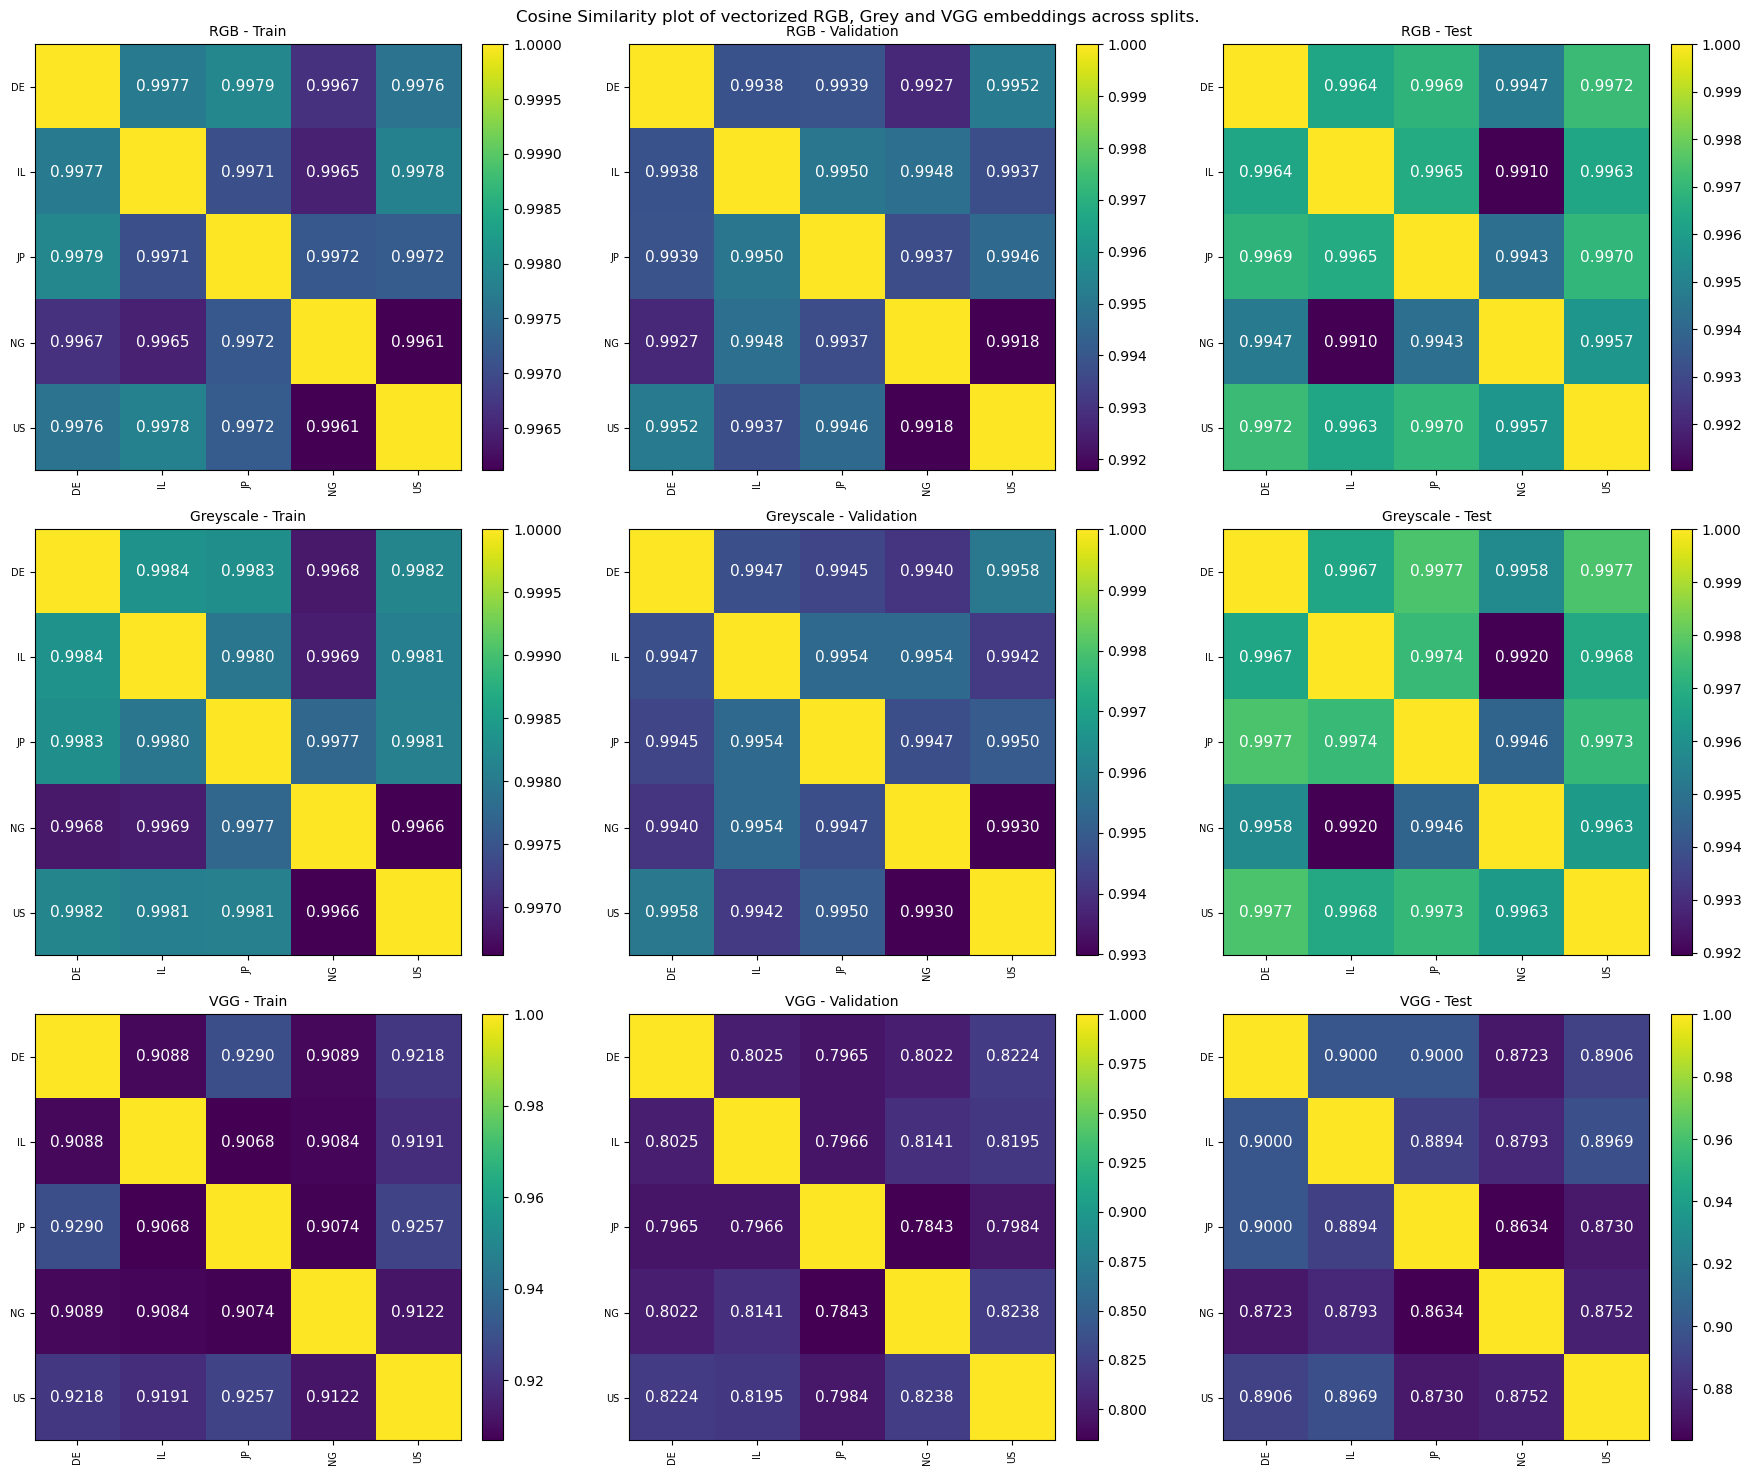

In [46]:
plot_3x3_similarity_superplot(sim_matrices_rgb, sim_matrices_grey, sim_matrices_vgg)

# Q4 - Model evaluation across datasets

In this section we ask the question of model performance for classification of images. We will use the following strategy:

For rgb and greyscale vectors, we will use the following models: SVM, RF, Adaboost and a custom constructed MLP.

For the original image data, we will fine-tune the Resnet-50 model for our purpose of classifying a country based on the image.

### Traditional ML

For this section, we will train the following models: SVM, RF and Adaboost models. For each model we will benchmark with RGB, greyscale and VGG vector data.

In [86]:
ml_models = {
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Before beginning, we will remap the labels to values from 0 to 4 and apply it across the dataframes
def remap_labels(y_train, y_val, y_test):
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    class_names = label2country([cls for cls in le.classes_])
    return y_train_enc, y_val_enc, y_test_enc, class_names

def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    ax.set_title(title)
    plt.colorbar(im, ax=ax)

    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Annotate each cell
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

def plot_confusion_supergrid(confusion_data, label_names, n_cols=2, fig_save = True, file_name = "confusion_matrices", sup_title = "Confusion Matrices"):
    n = len(confusion_data)
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    axes = axes.flatten()

    for idx, (y_true, y_pred, title) in enumerate(confusion_data):
        cm = confusion_matrix(y_true, y_pred)
        ax = axes[idx]
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.set_title(title)

        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names, rotation=45)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, str(cm[i, j]),
                        ha='center', va='center',
                        color='white' if cm[i, j] > cm.max() / 2 else 'black')

    # Turn off any extra axes
    for idx in range(len(confusion_data), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.suptitle(f"{sup_title}", fontsize=14)
    if fig_save:
        plt.savefig(f"{file_name}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

def run_benchmark_on_dataset(data_matrices, data_name):
    X_train, y_train = data_matrices[0]
    X_val, y_val = data_matrices[1]
    X_test, y_test = data_matrices[2]

    # Remap string or unordered labels to consecutive integers
    y_train, y_val, y_test, class_names = remap_labels(y_train, y_val, y_test)

    confusion_data = []  # To store (y_true, y_pred, title) tuples
    results = []         # To store rows for the final DataFrame

    print(f"📁 Dataset: {data_name}")
    for model_name, model in ml_models.items():
        print(f"\n🔧 Model: {model_name}")

        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test)

        val_acc = accuracy_score(y_val, val_preds)
        test_acc = accuracy_score(y_test, test_preds)

        report = classification_report(
            y_test, test_preds, target_names=class_names, output_dict=True, zero_division=0
        )

        macro_precision = report['macro avg']['precision']
        macro_recall = report['macro avg']['recall']
        macro_f1 = report['macro avg']['f1-score']

        # Store metrics
        results.append({
            "Dataset": data_name,
            "Model": model_name,
            "Validation Accuracy": val_acc,
            "Test Accuracy": test_acc,
            "Precision": macro_precision,
            "Recall": macro_recall,
            "F1-Score": macro_f1,
            "Train Time (s)": train_time
        })

        # Store confusion matrices for final superplot
        confusion_data.append((y_val, val_preds, f"{data_name} - {model_name} - Val"))
        confusion_data.append((y_test, test_preds, f"{data_name} - {model_name} - Test"))

    # Create confusion matrix superplot
    plot_confusion_supergrid(confusion_data, class_names, file_name=f"{data_name}_confusion_matrices", sup_title=f"{data_name} Confusion Matrices")

    results_df = pd.DataFrame(results)
    results_df.index = results_df.apply(lambda row: f"{row['Dataset']} - {row['Model']}", axis=1)

    # Drop the old 'Dataset' and 'Model' columns if you don't want them
    results_df = results_df.drop(columns=["Dataset", "Model"])

    return results_df

In [78]:
data_for_training = [
    ("Flattened RGB", X_y_matrices_rgb),
    ("Flattened Greyscale", X_y_matrices_grey),
    ("VGG Embeddings", X_y_matrices_vgg),
]


Running benchmark for: Flattened RGB
📁 Dataset: Flattened RGB

🔧 Model: SVM

🔧 Model: Random Forest

🔧 Model: AdaBoost


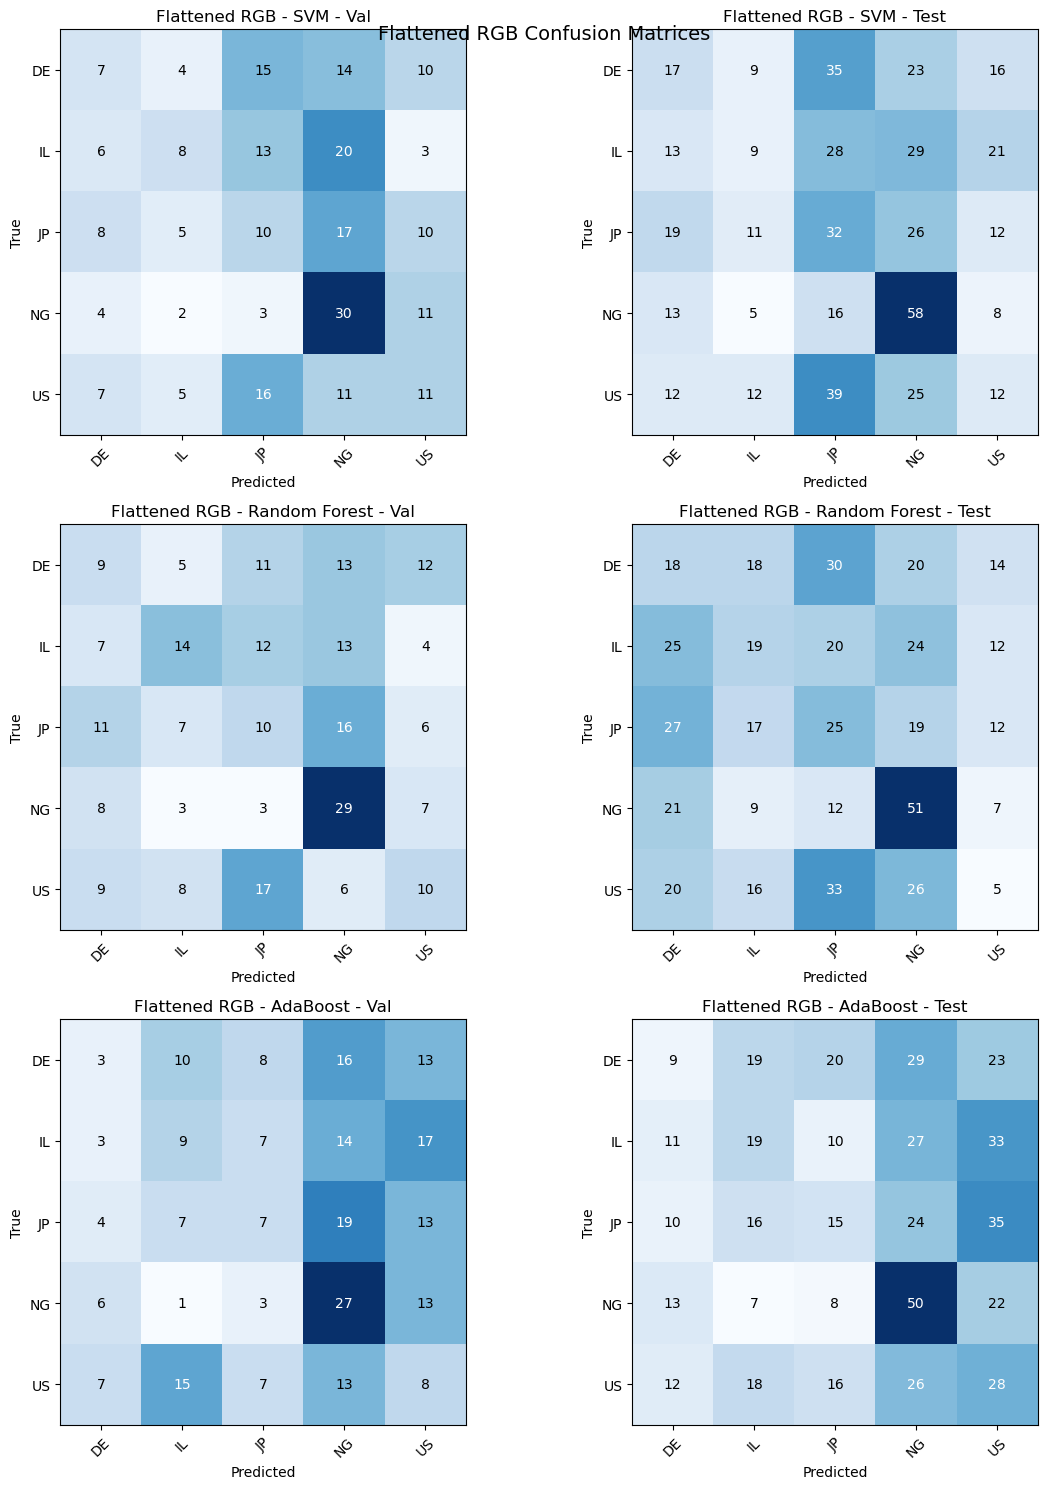


Running benchmark for: Flattened Greyscale
📁 Dataset: Flattened Greyscale

🔧 Model: SVM

🔧 Model: Random Forest

🔧 Model: AdaBoost


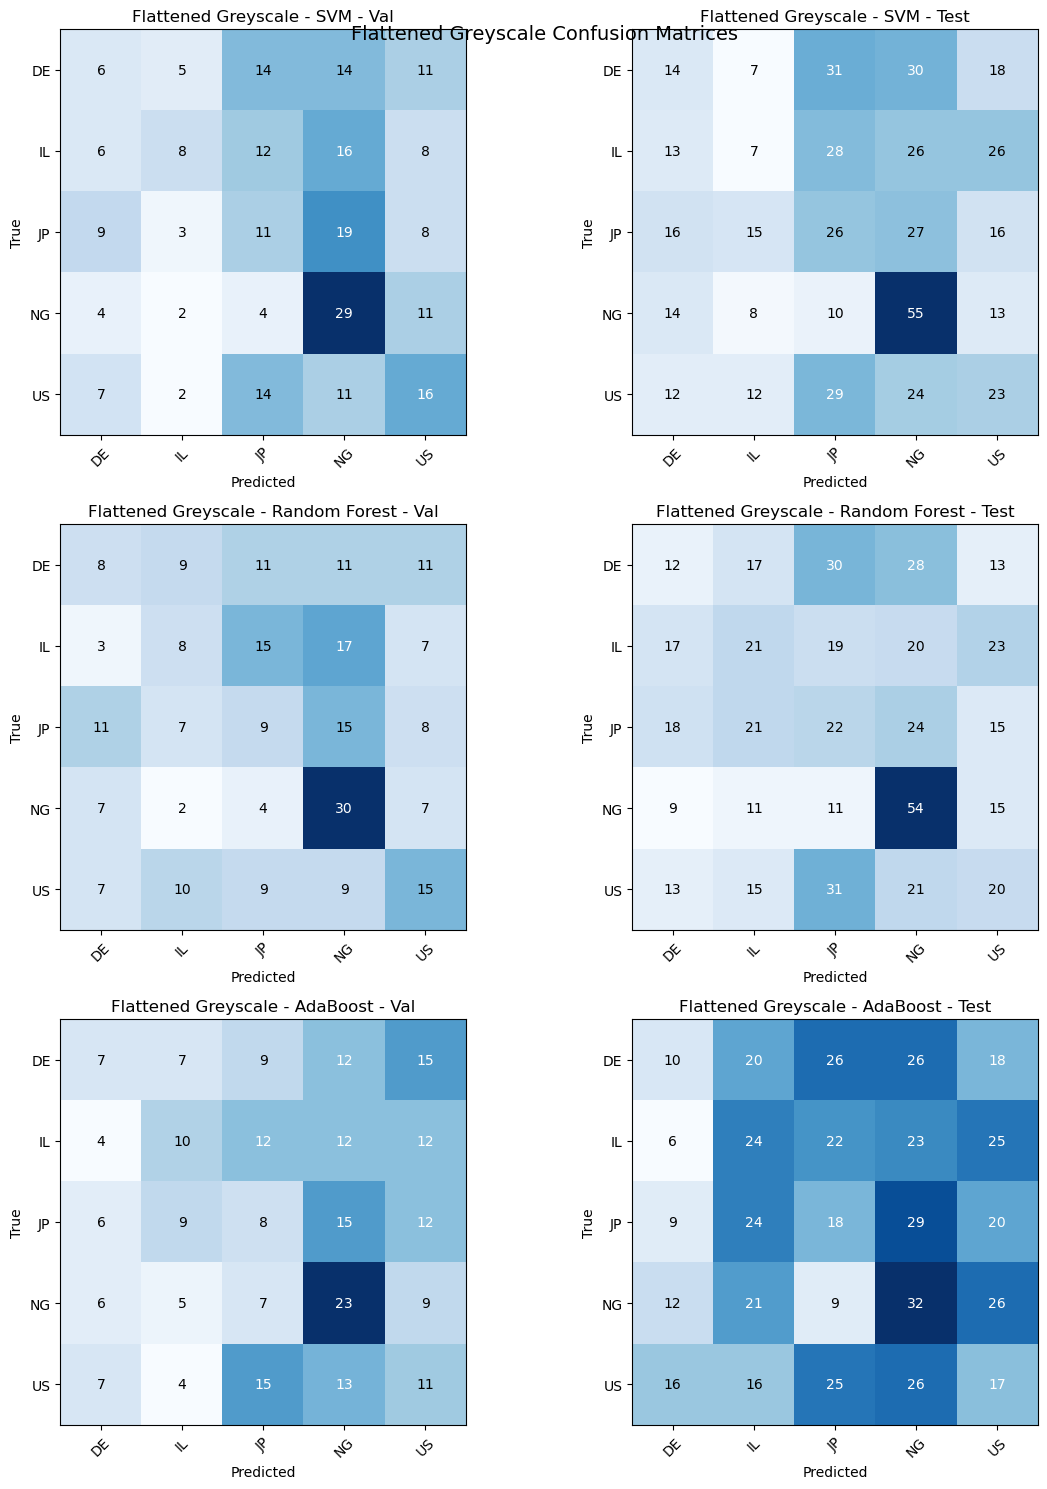


Running benchmark for: VGG Embeddings
📁 Dataset: VGG Embeddings

🔧 Model: SVM

🔧 Model: Random Forest

🔧 Model: AdaBoost


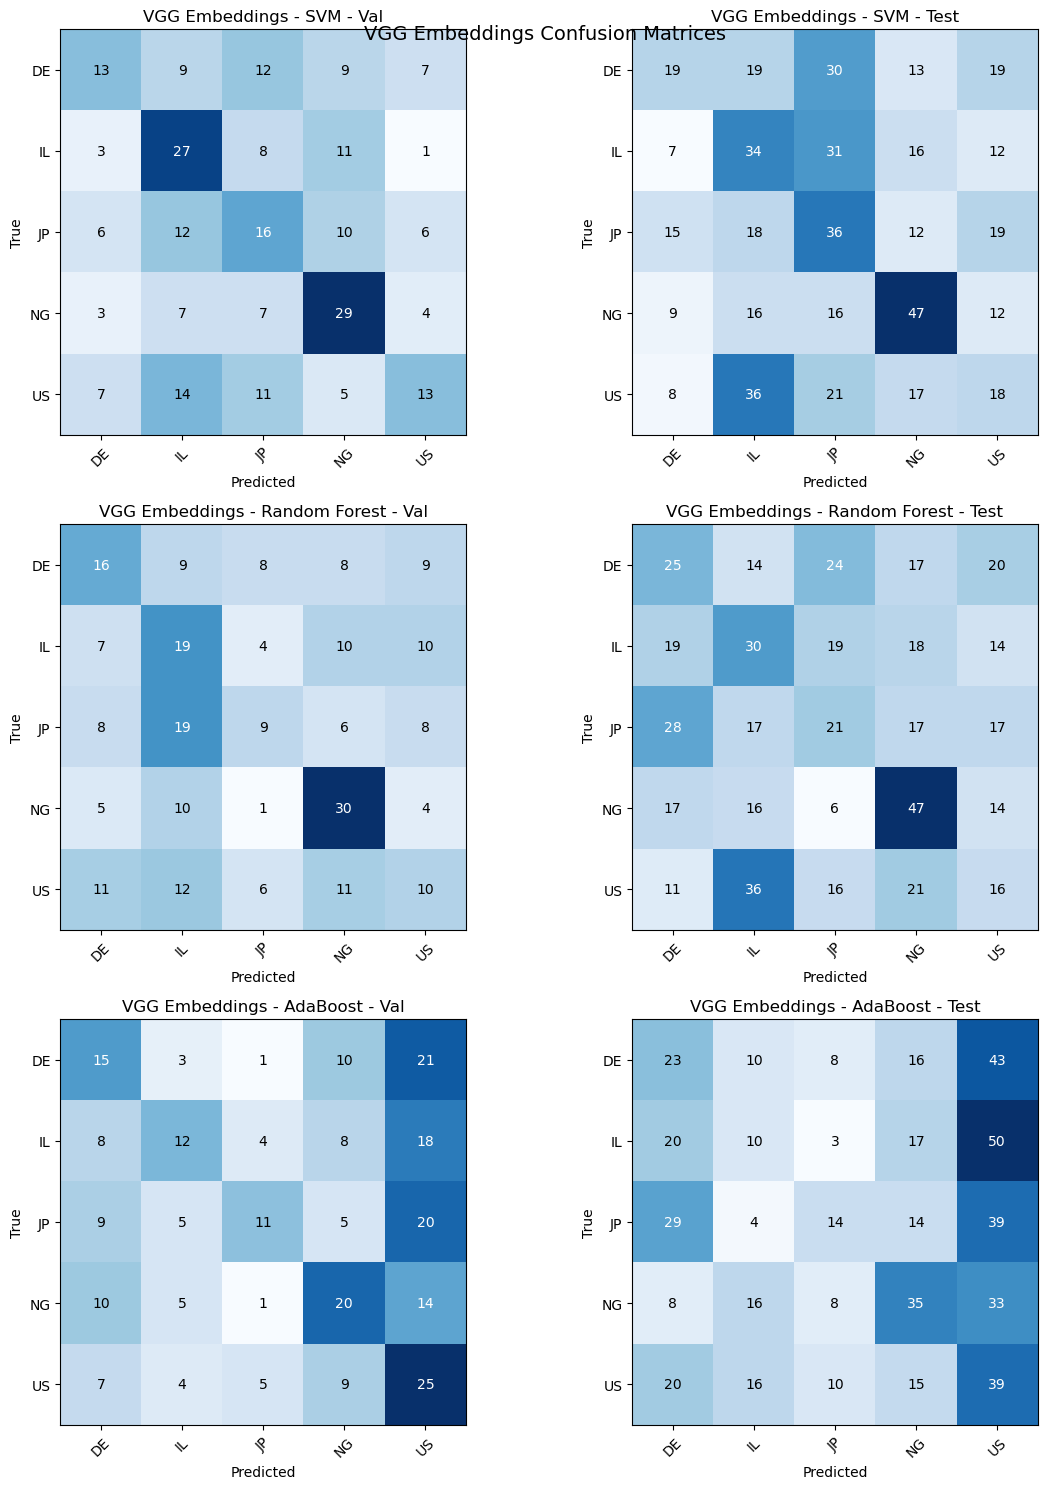

In [90]:
all_results = []

for data_name, data_matrices in data_for_training:
    print(f"\n==============================")
    print(f"Running benchmark for: {data_name}")
    results_df = run_benchmark_on_dataset(data_matrices, data_name)
    all_results.append(results_df)

# Combine all into a single DataFrame
final_df = pd.concat(all_results)

#run_benchmark_on_dataset(data_for_training[0][1], data_for_training[0][0])

In [91]:
final_df

,Validation Accuracy,Test Accuracy,Precision,Recall,F1-Score,Train Time (s)
Flattened RGB - SVM,0.264,0.256,0.234575,0.256,0.232229,18.512057
Flattened RGB - Random Forest,0.288,0.236,0.215058,0.236,0.220369,5.920014
Flattened RGB - AdaBoost,0.216,0.242,0.228126,0.242,0.225785,182.837331
Flattened Greyscale - SVM,0.280,0.250,0.226905,0.250,0.229265,12.425996
Flattened Greyscale - Random Forest,0.280,0.258,0.243113,0.258,0.245582,3.609387
Flattened Greyscale - AdaBoost,0.236,0.202,0.198584,0.202,0.196220,60.385696
VGG Embeddings - SVM,0.392,0.308,0.309057,0.308,0.302334,16.902468
VGG Embeddings - Random Forest,0.336,0.278,0.269774,0.278,0.272313,2.218331
VGG Embeddings - AdaBoost,0.332,0.242,0.257231,0.242,0.233184,41.652718


In [89]:
final_df.to_csv("model_benchmark.csv", float_format="%.4f")